In [222]:
import torch
import numpy as np
import pandas as pd
import os
import sys
import cv2
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from skimage.metrics import structural_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import asyncio
import glob
import shutil
from collections import Counter,defaultdict
sns.set_style("darkgrid")

In [2]:
# image_path = 'D:\\demo\\PressureMeterData\\PressureMeterPointer\\images\\val_pre'
# label_path = 'D:\\demo\\PressureMeterData\\PressureMeterPointer\\labels\\val_pre'
image_path = 'D:\\demo\\PressureMeterData\\MeterPointer\\images\\val'
label_path = 'D:\\demo\\PressureMeterData\\MeterPointer\\labels\\val_pre'

In [3]:
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '.', 'center', 'semi-pointer', 'scale']

In [4]:
# 读取每张图片和对应标签，进行计算
image_list = os.listdir(image_path)
for img in image_list:
    if img != 'img38.jpg':
        continue
    img_arr = cv2.imread(os.path.join(image_path, img))
    label_df = pd.read_csv(os.path.join(label_path, img.replace('jpg', 'txt')), sep=" ", header=None)
    label_df.columns = ['class', 'xcenter', 'ycenter', 'width', 'height']
    label_df['name'] = label_df['class'].apply(lambda x: class_names[x])
    # 寻找表盘中心点和指针尖点坐标
    center_c = label_df[label_df['name'] == 'center'][['xcenter', 'ycenter']].values[0]
    pointer_xywh = label_df[label_df['name'] == 'semi-pointer'][['xcenter', 'ycenter', 'width', 'height']].values[0]
    pointer_tip_c = np.array([pointer_xywh[0] - 1 / 2 * pointer_xywh[2], pointer_xywh[1] - 1 / 2 * pointer_xywh[3]])
    
    # 获取数字和中心坐标点
    # 使用k-means数字聚类
    numbers = label_df[~label_df['name'].isin(['scale', 'semi-pointer', 'center'])][['xcenter', 'ycenter', 'name']]
    features = numbers[['xcenter', 'ycenter']].values
    labels = numbers['name'].values
    choose_clusters, choose_ss = 1, 0  # 通过轮廓系数选定最优的聚类数
    for c in range(2, min(labels.shape[0], 16)):
        agg = KMeans(n_clusters=c)
        pre = agg.fit_predict(features)
        ss = silhouette_score(features, pre)
        if ss > choose_ss:
            choose_ss = ss
            choose_clusters = c
    print(f'choose clusters: {choose_clusters}')
    agg = KMeans(n_clusters=choose_clusters)
    pre = agg.fit_predict(features)
    # 相近的数字和刻度进行合并
    scale_numbers, scale_c = [], []
    scales = label_df[label_df['name'] == 'scale'][['xcenter', 'ycenter']].values
    for i in range(choose_clusters):
        ln_idx = np.argwhere(pre == i).flatten()
        tf, tl = features[ln_idx], labels[ln_idx]
        sort_idx = np.argsort(tf[:, 0].flatten())
        res_arr = tl[sort_idx]
        if '.' not in res_arr and res_arr[0] == '0' and len(res_arr) > 1:
            res_arr = res_arr[0] + '.' + res_arr[1:]
        scale_numbers.append(float(''.join(res_arr)))
        # 寻找离该数字最近的刻度
        avg_sc = tf.mean(axis=0)
        choose_idx = np.argmin(np.sum((scales - avg_sc)**2, axis=1))
        scale_c.append(scales[choose_idx])
        
    scale_numbers, scale_c = np.array(scale_numbers), np.array(scale_c)
    # 根据数据规律，对识别数字进行修正(假设能够识别到刻度和数字，数字内容可以不准确)
    scale_angle = np.array([np.arccos((sc[1] - center_c[1]) / np.sqrt(np.sum((sc - center_c)**2))) for sc in scale_c])
    scale_angle = np.array([scale_angle[i] if scale_c[i][0] <= center_c[0] else 2*np.pi - scale_angle[i] for i in range(len(scale_angle))])
    # 夹角从小到大排序，相当于按照顺时针给刻度值排序
    angle_sort_idx = np.argsort(scale_angle)
    scale_numbers, scale_c = scale_numbers[angle_sort_idx], scale_c[angle_sort_idx]
    # 修正，计算差值
    diff_sn = np.diff(scale_numbers)
    diff_str = np.array([f'{x:.2f}' for x in diff_sn])
    count_diff_str = Counter(diff_str)
    print(scale_numbers)
    if len(count_diff_str) > 1: # 说明存在刻度值识别错误
        print('刻度值存在错误，需要校正')
        interval = count_diff_str.most_common()[0][0]
        inter_val_first_pos = np.argwhere(diff_str == interval).flatten()[0]
        start_n = scale_numbers[inter_val_first_pos] - inter_val_first_pos * float(interval)
        end_n = scale_numbers[inter_val_first_pos] + (choose_clusters - 1 - inter_val_first_pos) * float(interval)
        scale_numbers = np.linspace(start_n, end_n, choose_clusters)
        print(scale_numbers)
    
    # 寻找距离指针尖点最近的刻度, 以及刻度最近的刻度数字
    choose_idx = np.argsort(np.sum((scale_c - pointer_tip_c)**2, axis=1))[:2]
    use_scale_c = scale_c[choose_idx]
    use_scale_numbers = scale_numbers[choose_idx]
    sort_idx = np.argsort(use_scale_numbers)
    use_scale_numbers = use_scale_numbers[sort_idx]
    use_scale_c = use_scale_c[sort_idx]
    
    # 计算中心点到刻度、中心点到针尖的直线斜率
    slope_tip = (pointer_tip_c[1] - center_c[1]) / (pointer_tip_c[0] - center_c[0])
    slope_scale_left = (use_scale_c[0][1] - center_c[1]) / (use_scale_c[0][0] - center_c[0])
    slope_scale_right = (use_scale_c[1][1] - center_c[1]) / (use_scale_c[1][0] - center_c[0])
    # 计算指针左边刻度到指针的夹角
    angle_left_tip = np.arccos((1 + slope_scale_left * slope_tip) / np.sqrt(1 + slope_scale_left ** 2) / np.sqrt(1 + slope_tip ** 2))
    angle_left_right = np.arccos((1 + slope_scale_left * slope_scale_right) / np.sqrt(1 + slope_scale_left ** 2) / np.sqrt(1 + slope_scale_right ** 2))
    
    res = use_scale_numbers[0] + angle_left_tip / angle_left_right * (use_scale_numbers[1] - use_scale_numbers[0])
    print(f'{res:.3f}')
    
    # 将识别结果画在图上并存储
#     output_arr = img_arr.copy()
#     cv2.putText(output_arr, f'{res:.3f}', (5, 50), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 0), 2)
#     cv2.imwrite(os.path.join(image_path, img.replace('.jpg', '_p.jpg')), output_arr)

choose clusters: 5
[ 0.   0.4  0.8 21.2  1.6]
刻度值存在错误，需要校正
[0.  0.4 0.8 1.2 1.6]
0.341


In [5]:
# import base64
# test_image_path = 'D:\\demo\\PressureMeterData\\PlateDataV2\\images\\val\\img38.jpg'
# im = cv2.imread(test_image_path)
# b = cv2.imencode('.jpg', im)[1]
# b64 = str(base64.b64encode(b), 'utf-8')
# with open('pressure_b64.txt', 'w') as f:
#     f.write(b64)
# cv2.imshow('main', im)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# 模型训练-数据集准备

In [6]:
# raw_image_path = 'D:\\demo\\yolov5\\runs\\detect\\pressure_plate_all\\crops\\pointer_plate'

In [7]:
# prefix = 'imageName'
# raw_image_list = os.listdir(raw_image_path)
# pm_list = [x for x in raw_image_list if prefix in x]

In [8]:
# pm_list[:10]

In [9]:
# store_path = 'D:\\demo\\PressureMeterData\\pressure_meter'

In [10]:
# for fp in pm_list:
#     shutil.copyfile(os.path.join(raw_image_path, fp), os.path.join(store_path, fp))

In [11]:
# 数据集整理(文件重命名)
# train val split
# train_image_path = 'D:\\demo\\PressureMeterData\\PlateDataV2\\images\\train'
# train_label_path = 'D:\\demo\\PressureMeterData\\PlateDataV2\\labels\\train'
# image_label_path = 'D:\\demo\\PressureMeterData\\pp\\obj_train_data'
# n = 0
# all_name_list = [x.rstrip('.jpg') for x in os.listdir(image_label_path) if '.jpg' in x]
# for name in all_name_list:
#     shutil.copyfile(os.path.join(image_label_path, f'{name}.jpg'), os.path.join(train_image_path, f'img{n}.jpg'))
#     shutil.copyfile(os.path.join(image_label_path, f'{name}.txt'), os.path.join(train_label_path, f'img{n}.txt'))
#     n += 1

# 对压力表表盘进行聚类，在不同簇内进行采样，得到分布更为合理的样本集

In [94]:
raw_image_path = 'D:\\demo\\yolov5\\runs\\detect\\pressure_plate_all\\crops\\pointer_plate'
output_path = 'D:\\demo\\yolov5\\runs\\detect\\pressure_plate_all'

In [83]:
all_pm_list = os.listdir(raw_image_path)

In [84]:
features = []
split = 50
for i in all_pm_list:
    im = cv2.imread(os.path.join(raw_image_path, i))
    im_hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
    f = np.histogram(im, split)[0]
    f_hsv = np.histogram(im_hsv, split)[0]
    fe = np.concatenate([f, f_hsv]).flatten()
    features.append(fe)

In [87]:
features = np.array(features)

In [93]:
features.shape

(4956, 100)

In [98]:
# for c in range(2, 24):
#     agg = KMeans(n_clusters=c)
#     pre = agg.fit_predict(features)
#     ss = silhouette_score(features, pre)
#     if ss > choose_ss:
#         choose_ss = ss
#         choose_clusters = c
# print(f'choose clusters: {choose_clusters}')
choose_clusters = 24
agg = KMeans(n_clusters=choose_clusters)
pre = agg.fit_predict(features)

In [96]:
all_pm_list = np.array(all_pm_list)

In [99]:
# 将不同簇内的图片保存到不同的文件夹中
for i in range(choose_clusters):
    ln_idx = np.argwhere(pre == i).flatten()
    current_image_list = all_pm_list[ln_idx]
    output_path_c = os.path.join(output_path, f'cluster_{i}')
    if os.path.exists(output_path_c):
        shutil.rmtree(output_path_c)
    os.makedirs(output_path_c)
    for j in current_image_list:
        shutil.copyfile(os.path.join(raw_image_path, j), os.path.join(output_path_c, j))

In [122]:
# 挑选图片
start_i = 4
end_i = 23
selects = 50
for i in range(start_i, end_i + 1):
    use_path = os.path.join(output_path, f'cluster_{i}')
    select_path = os.path.join(output_path, f'cluster_{i}_select')
    if os.path.exists(select_path):
        shutil.rmtree(select_path)
    os.makedirs(select_path)
    im_list = os.listdir(use_path)
    # 随机挑选
    im_list_random = np.random.permutation(im_list)[:selects]
    for j in im_list_random:
        shutil.move(os.path.join(use_path, j), select_path)

In [121]:
np.random.permutation(['s', 'a', 'd'])

array(['d', 'a', 's'], dtype='<U1')

# 尝试通过FID、SSIM和PSNR计算相似性矩阵，剔除相似度较高的图片

In [123]:
test_path = 'D:\\demo\\yolov5\\runs\\detect\\pressure_plate_all\\cluster_6_select'

In [134]:
test_image_list = os.listdir(test_path)

In [255]:
test_im2 = cv2.imread(os.path.join(test_path, 'imageName_1656313210_53_21_1660091505464.jpg'))
test_im1 = cv2.resize(cv2.imread(os.path.join(test_path, 'imageName_1656313210_77_21_1660200097300.jpg')), 
                      test_im2.shape[:2][::-1])

In [238]:
cv2.imshow('im2', test_im2)
cv2.imshow('im1', test_im1)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [168]:
# 考虑FID需要经过一个网络模型，比较麻烦，PSNR相对容易些
def psnr(img1, img2):
    mse = np.mean((img1/1.0 - img2/1.0) ** 2)
    if mse < 1.0e-10:
        return 100
    return 10 * np.log10(255.0**2/mse)

In [256]:
structural_similarity(test_im1, test_im2, channel_axis=2)

0.44570042720999975

In [187]:
test_lens = len(test_image_list)
psnr_list = []
record_im = []
record_flag = False
psnr_threshold = 17
for i in range(test_lens):
    for j in range(i+1, test_lens):
        im_i = cv2.imread(os.path.join(test_path, test_image_list[i]))
        im_j = cv2.imread(os.path.join(test_path, test_image_list[j]))
        im_j = cv2.resize(im_j, im_i.shape[:2][::-1])
        p = psnr(im_i, im_j)
        if np.abs(p - psnr_threshold) <= 0.1 and not record_flag:
            record_im.append(test_image_list[i])
            record_im.append(test_image_list[j])
            record_flag = True
        psnr_list.append(p)

In [188]:
record_im

['imageName_1656313210_228599994_21_1662543200013.jpg',
 'imageName_1656313210_263_21_1661904109186.jpg']

In [182]:
# 分布直方图
psnr_list = np.array(psnr_list)

In [216]:
# 当2张图片psnr超过指定阈值时，删除标准差较小的图片
test_lens = len(test_image_list)
psnr_threshold = 16
delete_idx = []
for i in range(test_lens):
    for j in range(i+1, test_lens):
        im_i = cv2.imread(os.path.join(test_path, test_image_list[i]))
        im_j = cv2.imread(os.path.join(test_path, test_image_list[j]))
        im_j = cv2.resize(im_j, im_i.shape[:2][::-1])
        p = psnr(im_i, im_j)
        if p > psnr_threshold:
            std_ib = im_i[:, :, 0].std()
            std_ig = im_i[:, :, 1].std()
            std_ir = im_i[:, :, 2].std()
            std_jb = im_j[:, :, 0].std()
            std_jg = im_j[:, :, 1].std()
            std_jr = im_j[:, :, 2].std()
            std_i = (std_ib + std_ig + std_ir) / 3
            std_j = (std_jb + std_jg + std_jr) / 3
            if std_i >= std_j:
                delete_idx.append(j)
            else:
                delete_idx.append(i)
                break

In [217]:
delete_idx = np.unique(delete_idx)

In [218]:
test_out_path = 'D:\\demo\\yolov5\\runs\\detect\\pressure_plate_all\\cluster_6_select_auto'
if os.path.exists(test_out_path):
    shutil.rmtree(test_out_path)
os.makedirs(test_out_path)

In [184]:
record_im

['imageName_1656313210_119_52_1660732647517.jpg',
 'imageName_1656313210_193_22_1661299390872.jpg']

In [219]:
for i in range(test_lens):
    if i not in delete_idx:
        shutil.copyfile(os.path.join(test_path, test_image_list[i]), 
                        os.path.join(test_out_path, test_image_list[i]))

In [229]:
# SSIM
test_lens = len(test_image_list)
ssim_list = []
ssim_threshold = 0.9
for i in range(test_lens):
    for j in range(i+1, test_lens):
        im_i = cv2.imread(os.path.join(test_path, test_image_list[i]))
        im_j = cv2.imread(os.path.join(test_path, test_image_list[j]))
        im_j = cv2.resize(im_j, im_i.shape[:2][::-1])
        s = structural_similarity(im_i, im_j, channel_axis=2)
        ssim_list.append(s)

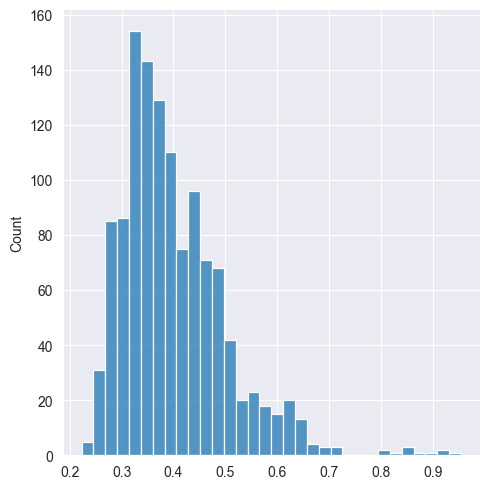

In [230]:
sns.displot(ssim_list)

In [240]:
test_lens = len(test_image_list)
ssim_threshold = 0.4
delete_idx = []
for i in range(test_lens):
    for j in range(i+1, test_lens):
        im_i = cv2.imread(os.path.join(test_path, test_image_list[i]))
        im_j = cv2.imread(os.path.join(test_path, test_image_list[j]))
        im_j = cv2.resize(im_j, im_i.shape[:2][::-1])
        p = structural_similarity(im_i, im_j, channel_axis=2)
        if p > ssim_threshold:
            std_ib = im_i[:, :, 0].std()
            std_ig = im_i[:, :, 1].std()
            std_ir = im_i[:, :, 2].std()
            std_jb = im_j[:, :, 0].std()
            std_jg = im_j[:, :, 1].std()
            std_jr = im_j[:, :, 2].std()
            std_i = (std_ib + std_ig + std_ir) / 3
            std_j = (std_jb + std_jg + std_jr) / 3
            if std_i >= std_j:
                delete_idx.append(j)
            else:
                delete_idx.append(i)
                break

In [241]:
delete_idx = np.unique(delete_idx)

In [242]:
test_out_path = r'D:\demo\yolov5\runs\detect\pressure_plate_all\cluster_6_select_auto'
if os.path.exists(test_out_path):
    shutil.rmtree(test_out_path)
os.makedirs(test_out_path)

In [243]:
for i in range(test_lens):
    if i not in delete_idx:
        shutil.copyfile(os.path.join(test_path, test_image_list[i]), 
                        os.path.join(test_out_path, test_image_list[i]))

In [267]:
type(glob.glob(os.path.join(test_path, '*')))

list

In [294]:
t = r'dsf/sdf/sdf'
re.split(r'\\|/', test_path)

['D:',
 'demo',
 'yolov5',
 'runs',
 'detect',
 'pressure_plate_all',
 'cluster_6_select']

In [295]:
delete_path = r'D:\demo\yolov5\runs\detect\pressure_plate_all\cluster_6_select'

In [307]:
for i in glob.glob(os.path.join(delete_path, '*')):
    if re.match(r'.*(81643|70538|23368|73745|92533|81893)', i):
        os.remove(i)